In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import keras
import time

Using TensorFlow backend.


In [4]:
    ratings_df = pd.read_csv('ratings.csv')

    # ALL TRAIN SET
    # Get only ratings between January 2008 to March 2013
    all_train_start = "09/01/1995"
    all_train_end = "01/03/2013"
    all_train_start_ts = time.mktime(dt.datetime.strptime(all_train_start, "%d/%m/%Y").timetuple())
    all_train_end_ts = time.mktime(dt.datetime.strptime(all_train_end, "%d/%m/%Y").timetuple())
    all_train_data = ratings_df.drop(['rating'], axis=1)

    # in date range
    all_train_data = all_train_data.loc[(all_train_data['timestamp'] >= all_train_start_ts) & (all_train_data['timestamp'] <= all_train_end_ts)]
    
    # only users 5 < rated_movies < 101
    all_train_data = all_train_data.groupby("userId").filter(lambda x: len(x) > 5 and len(x) < 101)

    # RECENT TRAIN SET
    # Get only ratings between January 2008 to March 2013
    train_start = "01/01/2008"
    train_end = "01/03/2013"
    train_start_ts = time.mktime(dt.datetime.strptime(train_start, "%d/%m/%Y").timetuple())
    train_end_ts = time.mktime(dt.datetime.strptime(train_end, "%d/%m/%Y").timetuple())
    train_data = ratings_df.drop(['rating'], axis=1)

    # in date range
    train_data = train_data.loc[(train_data['timestamp'] >= train_start_ts) & (train_data['timestamp'] <= train_end_ts)]
    # only users 5 < rated_movies < 101
    train_data = train_data.groupby("userId").filter(lambda x: len(x) > 5 and len(x) < 101)

    # DEV SET
    # Get only ratings between April 2014 to April 2015
    dev_start = "01/04/2013"
    dev_end = "01/04/2014"
    dev_start_ts = time.mktime(dt.datetime.strptime(dev_start, "%d/%m/%Y").timetuple())
    dev_end_ts = time.mktime(dt.datetime.strptime(dev_end, "%d/%m/%Y").timetuple())
    dev_data = ratings_df.drop(['rating'], axis=1)

    # in date range
    dev_data = dev_data.loc[(dev_data['timestamp'] >= dev_start_ts) & (dev_data['timestamp'] <= dev_end_ts)]
    # only users 5 < rated_movies < 101
    dev_data = dev_data.groupby("userId").filter(lambda x: len(x) > 5 and len(x) < 101)

    # TEST SET
    # Get only ratings between April 2015 to April 2016
    test_start = "02/04/2014"
    test_end = "01/04/2015"
    test_start_ts = time.mktime(dt.datetime.strptime(test_start, "%d/%m/%Y").timetuple())
    test_end_ts = time.mktime(dt.datetime.strptime(test_end, "%d/%m/%Y").timetuple())
    test_data = ratings_df.drop(['rating'], axis=1)

    # in date range
    test_data = test_data.loc[(test_data['timestamp'] >= test_start_ts) & (test_data['timestamp'] <= test_end_ts)]
    # only users 5 < rated_movies < 101
    test_data = test_data.groupby("userId").filter(lambda x: len(x) > 5 and len(x) < 101)

    all_train_data.columns = ['SessionId', 'ItemId', 'Time']
    train_data.columns = ['SessionId', 'ItemId', 'Time']
    dev_data.columns = ['SessionId', 'ItemId', 'Time']
    test_data.columns = ['SessionId', 'ItemId', 'Time']

    all_train_data.to_csv('processed_all_train.csv', sep='\t', index=False)
    train_data.to_csv('processed_train.csv', sep='\t', index=False)
    dev_data.to_csv('processed_dev.csv', sep='\t', index=False)
    test_data.to_csv('processed_test.csv', sep='\t', index=False)

In [5]:
from matplotlib import pyplot as plt

In [6]:
def preprocess_df(df):    
    n_items = len(train_data['ItemId'].unique())
    aux = list(train_data['ItemId'].unique())
    itemids = np.array(aux)
    itemidmap = pd.Series(data=np.arange(n_items), index=itemids)  # (id_item => (0, n_items))
    
    item_key = 'ItemId'
    session_key = 'SessionId'
    time_key = 'Time'
    
    data = pd.merge(df, pd.DataFrame({item_key:itemids, 'ItemIdx':itemidmap[itemids].values}), on=item_key, how='inner')
    data.sort_values([session_key, time_key], inplace=True)

    length = len(data['ItemId'])
        
    return data

In [7]:
def compute_dwell_time(df):
   
    times_t = np.roll(df['Time'], -1) # Take time row
    times_dt  = df['Time']            # Copy, then displace by one
    
    diffs = np.subtract(times_t, times_dt) # Take the pairwise difference
    
    length = len(df['ItemId'])
    
    # cummulative offset start for each session
    offset_sessions = np.zeros(df['SessionId'].nunique()+1, dtype=np.int32)
    offset_sessions[1:] = df.groupby('SessionId').size().cumsum() 
    
    offset_sessions = offset_sessions - 1
    offset_sessions = np.roll(offset_sessions, -1)
    
    # session transition implies zero-dwell-time
    # note: paper statistics do not consider null entries, 
    # though they are still checked when augmenting
    np.put(diffs, offset_sessions, np.zeros((offset_sessions.shape)), mode='raise')
        
    return diffs

In [8]:
# get paper statistics
def get_statistics(dts):
    filtered = np.array(list(filter(lambda x: int(x) != 0, dts)))
    pd_dts = pd.DataFrame(filtered)
    pd_dts.boxplot(vert=False, showfliers=False) # no outliers in boxplot
    plt.show()
    pd_dts.describe()

In [9]:
def join_dwell_reps(df, dt, threshold=2000):
    # Calculate d_ti/threshold + 1
    # then add column to dataFrame
    
    dt //= threshold
    dt += 1   
    df['DwellReps'] = pd.Series(dt.astype(np.int64), index=dt.index)
    #return df


In [10]:
def augment(df):    
    col_names = list(df.columns.values)[:3]
    print(col_names)
    augmented = np.repeat(df.values, df['DwellReps'], axis=0) 
    print(augmented[0][:3])  
    augmented = pd.DataFrame(data=augmented[:,:3],
                             columns=col_names)
    
    dtype = {'SessionId': np.int64, 
             'ItemId': np.int64, 
             'Time': np.float32}
    
    for k, v in dtype.items():
        augmented[k] = augmented[k].astype(v)
                             
    
    return augmented

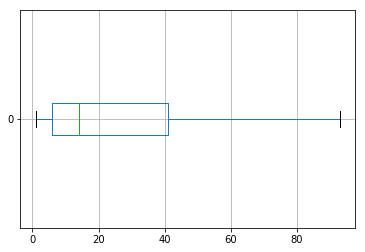

['SessionId', 'ItemId', 'Time']
[        18      56788 1204200841]


In [11]:
# load RSC15 preprocessed train dataframe
    PATH_TO_TRAIN = 'processed_train.csv'
    train_data = pd.read_csv(PATH_TO_TRAIN, sep='\t', dtype={'ItemId':np.int64})

    new_df = preprocess_df(train_data)
    dts = compute_dwell_time(new_df)

    get_statistics(dts)

    join_dwell_reps(new_df, dts, threshold=200000)

    # Now, we augment the sessions copying each entry an additional (dwellReps[i]-1) times
    df_aug = augment(new_df)
    df_aug.to_csv("processed_augmented_train.csv", index=False, sep='\t')